<!-- dom:TITLE: STAT 5102 Regression in Practice Final Project -->
# <center>Generalised Linear Model for Estimating Mortality Rate Using Development Indicators</center>


<!-- dom:AUTHOR: CHAN, Yiu Fung Frankie, 1155010561 -->
<!-- Author: -->  
**<h5><center>CHAN, Yiu Fung Frankie,  1155010561</center></h5>**  
<!-- dom:AUTHOR: LI Wai Lan, 1155118254 -->
<!-- Author: -->  
**<h5><center>LI Wai Lan,  1155118254</center></h5>** 
<!-- dom:AUTHOR: WONG, Tsz Wing, 1004666311 -->
<!-- Author: -->  
**<h5><center>WONG, Tsz Wing,  1004666311</center></h5>**
<!-- dom:AUTHOR: WONG, Yiu Chung, 1155017920 -->
<!-- Author: -->  
**<h5><center>WONG, Yiu Chung,  1155017920</center></h5>** 


Date: **Nov 20, 2018**

In this study, we investigate the dataset obtained from The World Bank: World Development Indicators. A Generalised Linear Model is used to perform a prediction analysis on the response variable: Mortality rate, using ???(number) predictor variables.

In [200]:
import scipy
from sklearn.preprocessing import PolynomialFeatures
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

'darwin'

# Import data

In [201]:
#change working directory to 5102 project folder
from sys import platform

current_OS = platform
if current_OS == "darwin" #MacOS
    os.chdir(r"/Users/chung/Google Drive/2018R1 Regression in Practice (STAT5102)/5012 Project")

#read project_data.sas7bdat
world_bank = pd.read_sas(r"project_data.sas7bdat", encoding="utf-8")

# Preliminary data wrangling 

In [202]:
#Drop the column Year and YearCode
world_bank.drop(["Year", "YearCode"], axis=1, inplace = True)

#remove columns with more than 20% Nan
na_portion = world_bank.isna().sum() / len(world_bank)
world_bank = world_bank.loc[:, na_portion < .2]

#remove case if Mortality rate, under-5 (per 1,000 live births) is Nan
world_bank = world_bank.loc[world_bank["Mortality rate, under-5 (per 1,0"].notnull(),:] 

In [203]:
#import functions for converting country code into continents codes
import pycountry #pycountry provides the ISO databases for the standards:
from pycountry_convert import (
    map_countries,
    country_alpha2_to_country_name,
    country_name_to_country_alpha2,
    country_alpha3_to_country_alpha2,
    country_alpha2_to_continent_code,
    COUNTRY_NAME_FORMAT_UPPER
)

#convert country code into continents codes
continents = []
fail_codes = []
for country_code in world_bank["Country Code"]:
    try:
        alpha2 = country_alpha3_to_country_alpha2(country_code)
        continent = country_alpha2_to_continent_code(alpha2)
    except KeyError:
        fail_codes.append(country_code)
        continents.append("999") #temporary place holder
    else:    
        continents.append(continent)

In [204]:
#see what's in the continents list variable
set(continents)

{'999', 'AF', 'AS', 'EU', 'NA', 'OC', 'SA'}

In [205]:
#insert continents into the world_bank dataframe
#insert as column 2, named "Continent"
world_bank.insert(2, "Continent", continents)

In [206]:
#manually impute fail codes
fail_codes_continents = ["EU", "AF", "EU", "AS", "AS"] #in this order. I checked manually.
fail_code_dict = dict(zip(fail_codes, fail_codes_continents))

#for columns with Country Code that matches elements in the fail_codes variable, 
#replace their Continent value (whcih should be 999 for now) with the elements in fail_codes_continents
for code, continent in fail_code_dict.items():
    world_bank.loc[world_bank["Country Code"] == code, "Continent"] = continent

In [212]:
show_all = 0
if show_all:
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(world_bank)
else:
    display(world_bank)

,Country Name,Country Code,Continent,Adjusted savings: education expe,Adolescent fertility rate (birth,Age dependency ratio (% of worki,"Age dependency ratio, young (% o",Agricultural land (% of land are,"Birth rate, crude (per 1,000 peo","Fertility rate, total (births pe",...,"Inflation, GDP deflator (annual","Life expectancy at birth, female","Life expectancy at birth, male (","Life expectancy at birth, total","Mortality rate, infant (per 1,00","Mortality rate, under-5 (per 1,0",Mortality rate Gender Difference,Population growth (annual %),"Immunization, DPT (% of children","Immunization, measles (% of chil"
0,Afghanistan,AFG,AS,NaN,99.095600,103.119626,98.722026,58.123668,37.952000,5.659,...,9.437795,60.877,58.384,59.600098,74.3,103.7,6.3,2.458417,66.0,62.0
1,Albania,ALB,EU,2.842804,16.994600,49.098446,34.036210,43.843066,12.607000,1.741,...,3.459343,80.149,73.959,76.978512,16.1,18.1,3.4,-0.033072,99.0,99.0
2,Algeria,DZA,AF,4.467196,9.894599,46.741610,39.796430,17.370914,24.514000,2.817,...,16.119976,72.229,69.081,70.616610,18.4,21.5,4.8,1.850438,95.0,95.0
4,Andorra,ADO,EU,2.889150,NaN,NaN,NaN,42.765957,9.800000,1.220,...,NaN,NaN,NaN,NaN,2.9,3.5,0.7,-0.960625,99.0,99.0
5,Angola,AGO,AF,3.516770,178.994000,100.915476,96.050884,46.835646,46.327000,6.218,...,22.393924,52.138,49.241,50.654171,104.6,173.1,16.6,3.235950,91.0,93.0
6,Antigua and Barbuda,ATG,NA,2.159410,51.755000,50.300659,39.428660,20.454545,16.966000,2.130,...,-0.010767,77.795,72.990,75.333902,9.8,10.6,2.3,1.075310,98.0,98.0
7,Argentina,ARG,SA,6.009790,55.372400,55.033758,38.566710,53.611114,17.188000,2.215,...,NaN,79.462,72.046,75.663561,13.3,14.8,3.0,0.872126,94.0,98.0
8,Armenia,ARM,AS,2.219690,27.481600,45.059361,29.758869,60.919944,14.140000,1.738,...,7.768715,77.657,70.946,74.219659,16.2,18.2,4.1,-0.157056,94.0,97.0
10,Australia,AUS,OC,4.775350,13.645400,47.909932,28.019034,51.882900,13.120148,1.870,...,0.886791,84.000,79.500,81.695122,4.2,5.0,1.2,1.306922,92.0,94.0
11,Austria,AUT,EU,5.288180,6.926000,48.328841,21.881827,38.405999,9.400000,1.440,...,1.440785,83.200,77.700,80.382927,3.5,4.2,0.9,0.292402,83.0,76.0


In [226]:
#export world_bank to excel file to share with groupmates (19 Nov 2018)
share = 0
if share:
    writer = pd.ExcelWriter('world_bank.xlsx')
    world_bank.to_excel(writer, 'Sheet1')
    writer.save()

# Exploratory Data Analysis

Not all variables are useful in the dataset. Some might be highly correlated with each other and thus create redundency and colinearity/multicolinearity.

Let's start by looking at the response variable, i.e. the Mortality rates

In [209]:
mortality_rates = list(world_bank.columns)
mortality_rates = [item for item in mortality_rates if item.startswith('Mortality')]
corr = world_bank[mortality_rates].corr()
corr.style.background_gradient(low=.9)

,"Mortality rate, infant (per 1,00","Mortality rate, under-5 (per 1,0","Mortality rate, under-5, female","Mortality rate, under-5, male (p"
"Mortality rate, infant (per 1,00",1,0.984862,0.982495,0.986274
"Mortality rate, under-5 (per 1,0",0.984862,1,0.999568,0.999681
"Mortality rate, under-5, female",0.982495,0.999568,1,0.99851
"Mortality rate, under-5, male (p",0.986274,0.999681,0.99851,1


We see that everything is highly corrrelated; they are essentially the same measure. Highly correlated predictors are result in in stability in our estimator as well as increased variance. 

Not only do these variables covary, their vaule are also extremely similar to each other. It is very tempting for us to just a single one of these to predict Mortality rate, infant (per 1,000 births). Let's do this and see what's gonna happen if we just pick one of these predictors to predict Mortality rate, under-5 (per 1,000 births)?

'R^2: 0.9235308462943443'

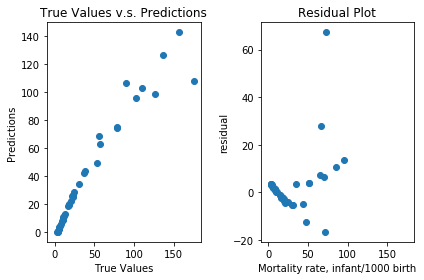

In [210]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(world_bank["Mortality rate, infant (per 1,00"].values, 
                                                    world_bank["Mortality rate, under-5 (per 1,0"].values, 
                                                    test_size=0.2, 
                                                    random_state = 5102)


X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)


lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
residuals = y_test - predictions

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, sharex = True)
ax1.scatter(y_test, predictions)
ax1.set_xlabel("True Values")
ax1.set_ylabel("Predictions")
ax1.set_title("True Values v.s. Predictions")

ax2.scatter(X_test, residuals)
ax2.set_xlabel("Mortality rate, infant/1000 birth")
ax2.set_ylabel("residual")
ax2.set_title("Residual Plot")
plt.tight_layout()

"R^2: " + str(model.score(X = X_test, y = y_test))

We see that although the test R square is close to 1, the residual plot is showing some very bizarre pattern: the error does not remain constant as infant mortality rate increase. This suggests either heteroscedasticity or nonlinear relationship between predictor and outcome.

The bottom line is, we cannot use Simple Linear Regression (OLS) simply because high correlation between predictor and outcome. We will not further investigate (OLS) in this report.

How about the other two mortality indicators? After some eyeball investigation, it is not difficult to see that our response variable is merely the average of the sum of Male/Female mortality rate. Hence we will not include these two into our analysis because they are essentially the same thing as our response variable. However, it might be interesting to see how the DIFFERENCE in Male/Female mortality rate affects our response variable. Therefore we can consider adding the DIFFERENCE in Male/Female mortality rate into our dataset.

In [211]:
Mortality_gender_diff = (world_bank["Mortality rate, under-5, male (p"] -
                         world_bank["Mortality rate, under-5, female"])
#add gender difference
world_bank.insert(23, "Mortality rate, Gender Difference", Mortality_gender_diff) 
#remove mortality rate for male and female
world_bank.drop(["Mortality rate, under-5, male (p", "Mortality rate, under-5, female"], axis=1,inplace=True)

# Coefficient of Variation
Compare spread of each numeric variables

In [214]:
world_bank_numeric = world_bank.copy() #make copy of dataset so don't mess up
world_bank_numeric = world_bank_numeric.iloc[:, 3:]
np.std(world_bank_numeric)/np.mean(world_bank_numeric)

Adjusted savings: education expe    0.452114
Adolescent fertility rate (birth    0.815479
Age dependency ratio (% of worki    0.312987
Age dependency ratio, young (% o    0.477310
Agricultural land (% of land are    0.552921
Birth rate, crude (per 1,000 peo    0.482061
Fertility rate, total (births pe    0.506147
GDP (constant 2005 US$)             4.123690
GDP growth (annual %)               0.959985
GDP per capita, PPP (constant 20    1.078324
Health expenditure per capita (c    1.696693
Health expenditure, public (% of    0.598193
Health expenditure, public _0001    0.394018
Inflation, GDP deflator (annual     1.085141
Life expectancy at birth, female    0.141148
Life expectancy at birth, male (    0.131955
Life expectancy at birth, total     0.135802
Mortality rate, infant (per 1,00    0.926710
Mortality rate, under-5 (per 1,0    1.058523
Mortality rate Gender Difference    0.843964
Population growth (annual %)        0.967304
Immunization, DPT (% of children    0.143102
Immunizati

Some variables shows extreme variation. e.g. GDP (constant 2005 US$) 

# Plotting distributions of numeric variables

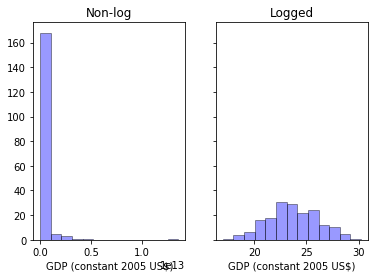

In [225]:
plot_data = world_bank_numeric["GDP (constant 2005 US$)"].dropna()
plot_data_log = np.log(plot_data)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.set_title("Non-log")
ax2.set_title("Logged")

plot_1 = sns.distplot(plot_data, hist=True, kde=False,
                      bins=int(plot_data.shape[0]**.5), 
                      color = 'blue',
                      hist_kws={'edgecolor':'black'},
                      ax=ax1)

plot_2 = sns.distplot(plot_data_log, hist=True, kde=False,
                      bins=int(plot_data_log.shape[0]**.5), 
                      color = 'blue',
                      hist_kws={'edgecolor':'black'},
                      ax=ax2)


In [216]:
scipy.stats.moment(hihi, moment=3)

NameError: name 'hihi' is not defined

Might have to drop cases if too many Nan, but wait until after variabel selection.

lots = world_bank.T.isna().sum() > 5

lots.sum()

# See how many  polynomial features can there be using the PolynomialFeatures function; to generate quadratic terms for Polynomial regression

In [141]:
#example
#test PolynomialFeatures function
data = pd.DataFrame.from_dict({
    'x': np.random.randint(low=1, high=10, size=5),
    'y': np.random.randint(low=-1, high=1, size=5),
})

p = PolynomialFeatures(degree=2).fit(data)
p.get_feature_names(data.columns)

['1', 'x', 'y', 'x^2', 'x y', 'y^2']

In [480]:
p.transform(data)

array([[ 1.,  2., -1.,  4., -2.,  1.],
       [ 1.,  3.,  0.,  9.,  0.,  0.],
       [ 1.,  6.,  0., 36.,  0.,  0.],
       [ 1.,  7.,  0., 49.,  0.,  0.],
       [ 1.,  8., -1., 64., -8.,  1.]])

In [540]:
#make a copy of our dataset: dont mess with our dataset
#impute data with mean coz PolynomialFeatures function can't work with dataset with missing data
poly = world_bank_numeric.drop(["Mortality rate, under-5 (per 1,0"], axis=1)
poly = poly.fillna(world_bank_copy.mean())

#have to deal with continent column.
degree = 2
quadratic_terms = PolynomialFeatures(degree = degree).fit(poly)
num_terms = len(quadratic_terms.get_feature_names(poly.columns))

#transform data into their corrosponding quadratic form
quadratic_data = quadratic_terms.transform(poly)
quadratic_data = pd.DataFrame(data = quadratic_data)

"There are a total of " + str(num_terms) + " first, second, and interaction terms"

'There are a total of 300 first, second, and interaction terms'

# PCA on 1st order variables

In [515]:
from sklearn.preprocessing import StandardScaler
# Separating out the features
x = world_bank_numeric.drop(["Mortality rate, under-5 (per 1,0"], axis=1).values
# Separating out the target
y = world_bank_numeric["Mortality rate, under-5 (per 1,0"].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

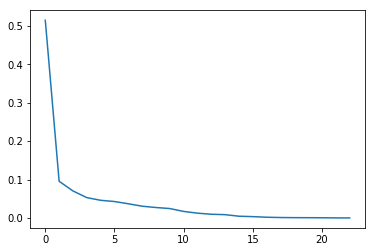

In [502]:
from sklearn.decomposition import PCA
pca = PCA(n_components=x.shape[1])
principalComponents = pca.fit_transform(x)
var = pca.explained_variance_ratio_
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
plt.plot(var)

# PCA on 2nd order variables

In [541]:
from sklearn.preprocessing import StandardScaler
# Separating out the features
quadratic_x = quadratic_data
# Separating out the target
quadratic_y = world_bank_numeric["Mortality rate, under-5 (per 1,0"].values
# Standardizing the features
quadratic_x = StandardScaler().fit_transform(quadratic_x)

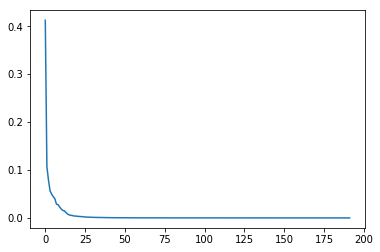

In [556]:
from sklearn.decomposition import PCA
quadratic_pca = PCA(n_components = quadratic_x.shape[1])
principalComponents = quadratic_pca.fit_transform(quadratic_x)
quadratic_var = quadratic_pca.explained_variance_ratio_
quadratic_var1 = np.cumsum(np.round(quadratic_var, decimals=4)*100)
plt.plot(quadratic_var)

In [557]:
variation_cutoff = 95
PC_count = len(quadratic_var1[quadratic_var1 < variation_cutoff])

(str(PC_count) + 
 " principle components (generated from 1st, 2nd, and interaction terms) are required to explain " +
 str(variation_cutoff) +
 "% of variation.")

'17 principle components (generated from 1st, 2nd, and interaction terms) are required to explain 95% of variation.'